# Deep Net

Now that we've got all the data, in arrays, and normalized, it's time to train a neural net.

In [1]:
import os
from PIL import Image
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
from IPython.display import display, Markdown, clear_output
from time import time
import tensorflow as tf
%matplotlib inline

## Load preprocessed dataset

In [2]:
with open('data/combined.pickle', 'rb') as f:
    data_dict = pickle.load(f)

X_train = data_dict['X_train']
y_train = data_dict['y_train']
X_test = data_dict['X_test']
y_test = data_dict['y_test']
X_valid = data_dict['X_valid']
y_valid = data_dict['y_valid']

del data_dict # Free all the mallocs!

print("Train shape: %s, %s" % (X_train.shape, y_train.shape))
print("Test shape: %s, %s" % (X_test.shape, y_test.shape))
print("Valid shape: %s, %s" % (X_valid.shape, y_valid.shape))

Train shape: (15000, 128, 128), (15000, 128, 128)
Test shape: (2500, 128, 128), (2500, 128, 128)
Valid shape: (2500, 128, 128), (2500, 128, 128)


## Reformat tensor
So it will fit our encoder/decoder architecture

In [3]:
num_channels = 1 # only grey

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, dataset.shape[1] * dataset.shape[2])).astype(np.float32)
    labels = labels.reshape((-1, labels.shape[1] * labels.shape[2])).astype(np.float32)
    return dataset, labels

print("Train shape: %s, %s" % (X_train.shape, y_train.shape))
X_train, y_train = reformat(X_train, y_train)
X_test, y_test = reformat(X_test, y_test)
X_valid, y_valid = reformat(X_valid, y_valid)

print("Test shape: %s, %s" % (X_test.shape, y_test.shape))
print("Valid shape: %s, %s" % (X_valid.shape, y_valid.shape))

Train shape: (15000, 128, 128), (15000, 128, 128)
Test shape: (2500, 16384), (2500, 16384)
Valid shape: (2500, 16384), (2500, 16384)


## Define a CNN

In [48]:
# hidden parameters
n_hidden_1 = 256 # 1st layer num features
n_hidden_2 = 128 # 2nd layer num features
n_input = X_train.shape[1] # data shape

# parameters
intial_stddev = 0.1
learning_rate = 0.01
training_epochs = 20
batch_size = 256
display_step = 1
examples_to_show = 10

# activation
activate = tf.nn.sigmoid
# activate = tf.nn.relu
# activate = tf.tanh

# This neural net is composed of 2 steps,
# the first it encodes the data, with 1 hidden layer,
# the second does the opposite, converts it back to
# the original shape

# Encode
def encode(x):
    # First layer
    layer_1 = activate(tf.add(tf.matmul(x, W['encoder_h1']), b['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = activate(tf.add(tf.matmul(layer_1, W['encoder_h2']), b['encoder_b2']))
    return layer_2

# Decode
def decode(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = activate(tf.add(tf.matmul(x, W['decoder_h1']), b['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = activate(tf.add(tf.matmul(layer_1, W['decoder_h2']), b['decoder_b2']))
    return layer_2

graph = tf.Graph()
with graph.as_default():

    # input variables
    tf_X = tf.placeholder(tf.float32, shape=(batch_size, n_input))
    tf_y = tf.placeholder(tf.float32, shape=(batch_size, n_input))
    tf_X_valid = tf.constant(X_valid)
    tf_X_test = tf.constant(X_test)

    # weights / slopes
    W = {
        'encoder_h1': tf.Variable(tf.truncated_normal([n_input, n_hidden_1], stddev=intial_stddev)),
        'encoder_h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], stddev=intial_stddev)),
        'decoder_h1': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_1], stddev=intial_stddev)),
        'decoder_h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_input], stddev=intial_stddev))
    }
    # biases / intercepts
    b = {
        'encoder_b1': tf.Variable(tf.truncated_normal([n_hidden_1], stddev=intial_stddev)),
        'encoder_b2': tf.Variable(tf.truncated_normal([n_hidden_2], stddev=intial_stddev)),
        'decoder_b1': tf.Variable(tf.truncated_normal([n_hidden_1], stddev=intial_stddev)),
        'decoder_b2': tf.Variable(tf.truncated_normal([n_input], stddev=intial_stddev))
    }
    
    # Execute sequence of encoding -> decoding to
    # generate predictions
    y_pred = decode(encode(tf_X))
    
    # Our goal is to reduce the mean between the originals and the predictions.
    # This value is squared to be more aggressive with distant values
    loss = tf.reduce_mean(tf.pow(tf_y - y_pred, 2))
    
    # Learning rate with exponential decay
    global_step = tf.Variable(0, trainable=False) 
    learning_rate = tf.train.exponential_decay(0.05, global_step, 100000, 0.96, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()


In [49]:
# Accuracy is the difference between both images
def accuracy(predictions, labels):
    return 1. - np.mean(np.abs(predictions - labels))

Minibatch loss at step 2000: 0.325123
Minibatch accuracy: 0.517
Validation accuracy: 0.519


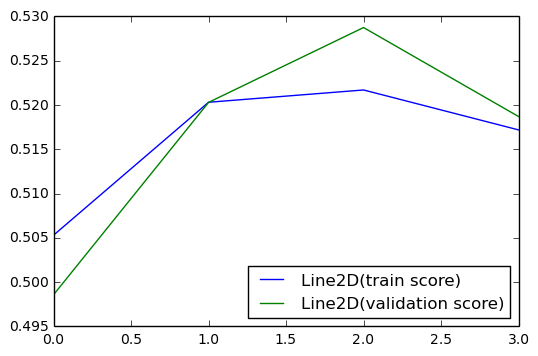

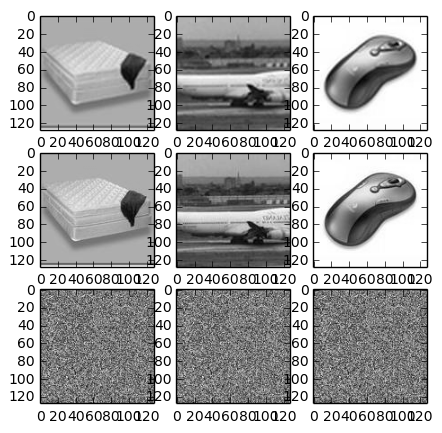

Model saved in file: model_step_2000_chart_ste_4.ckpt
...................................................................................................

In [ ]:
save_step = 1000
preview_step = 500
examples_to_show = 3

keep_training = True

# Accuracy arrays to draw a chart
minibatch_acc = [];
val_acc = [];
test_acc = [];

def show_stats():
    handle1, = plt.plot(minibatch_acc, label="train score")
    handle2, = plt.plot(val_acc, label="validation score")
    plt.legend([handle1, handle2], loc="best")
    plt.show()
    plt.draw()
    
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    
    print('Initialized')
    step = 0;
    while keep_training:
        print(".", end="")
        
        # SGD
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        batch_data = X_train[offset:(offset + batch_size), :]
        batch_labels = y_train[offset:(offset + batch_size), :]
        
        # Data passed into the session
        feed_dict = {
            tf_X : batch_data, 
            tf_y : batch_labels,
            global_step: step
        }
        
        # Run session
        _, l = session.run(
          [optimizer, loss], feed_dict=feed_dict)
        
        # Increment global step to decrease learning ratio
        step = step + 1
        
        # Showing training progress with a chart and images
        if (step % preview_step == 0):
            train_predictions = session.run(y_pred, feed_dict= feed_dict)
            m_acc = accuracy(train_predictions, batch_labels)
            
            offset = (step * batch_size) % (y_valid.shape[0] - batch_size)
            valid_sample = X_valid[offset:(offset + batch_size)]
            valid_label_sample = y_valid[offset:(offset + batch_size)]
            valid_predictions = session.run(y_pred, feed_dict= {
                tf_X: valid_sample
            })
            v_acc = accuracy(valid_predictions, valid_label_sample)
            
            minibatch_acc.append(m_acc)
            val_acc.append(v_acc)

            clear_output()
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.3f" % m_acc)
            print("Validation accuracy: %.3f" % v_acc)
            
            show_stats()
            
            # Compare original images with their reconstructions
            f, a = plt.subplots(3, 3, figsize=(5, 5))
            for i in range(examples_to_show):
                image_shape = (128, 128)
                a[0][i].imshow(np.reshape(valid_sample[i], image_shape), cmap="gray")
                a[1][i].imshow(np.reshape(valid_label_sample[i], image_shape), cmap="gray")
                a[2][i].imshow(np.reshape(valid_predictions[i], image_shape), cmap="gray")
            f.show()
            plt.show()

            
        if (step % save_step == 0):
            save_path = saver.save(session, ("model_global_step_%s_chart_step_%s.ckpt" % (step, len(minibatch_acc))))
            print("Model saved in file: %s" % save_path)
            
    test_predictions = session.run(y_pred, feed_dict= {
        tf_X: X_test[:n_hidden_1]
    })
    print('Test accuracy: %.1f' % accuracy(test_predictions[:n_hidden_1], y_test[:n_hidden_1]))

## Run this to stop training